# StateGraph 

https://github.com/langchain-ai/langgraph/blob/main/examples/visualization.ipynb

**Visualization**
https://langchain-ai.github.io/langgraph/how-tos/visualization/

In [1]:
from langgraph.graph import StateGraph, MessageGraph, END

from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ChatMessage

from typing import Annotated
from typing import TypedDict

from IPython.display import Image, display

from langchain.globals import set_debug



## 1. Study add_messages behavior

https://github.com/langchain-ai/langgraph/blob/main/libs/langgraph/langgraph/graph/message.py

A new list of messages with the messages from `right` merged into `left`.  If a message in `right` has the same ID as a message in `left`, th   message from `right` will replace the message from `left`.

In [2]:
# Create a lists of messages
msgs1 = [HumanMessage(content="Hello", id="1")]
msgs2 = [AIMessage(content="Hi there!", id="2")]

list_1 = add_messages(msgs1, msgs2)

list_1

[HumanMessage(content='Hello', id='1'), AIMessage(content='Hi there!', id='2')]

In [3]:
msg3 = [AIMessage(content="This will override the earlier message!", id="2")]

list_2 = add_messages(list_1, msg3)

list_2

[HumanMessage(content='Hello', id='1'),
 AIMessage(content='This will override the earlier message!', id='2')]

## 2. StateGraph

In [4]:
# The messages key is annotated with the add_messages function, which tells LangGraph to append new messages to the existing list, 
# rather than overwriting it.
class AppState(TypedDict):
    messages : Annotated[list, add_messages]

# Dummy functions to represent the processing at a node in the graph
def  dummy_function(state: AppState):

    print(state)
    messages = state['messages']
    return {"messages": [AIMessage(content="hello there")]}

In [5]:
state_graph_builder = StateGraph(AppState)

# Add a node with the name 'A'
state_graph_builder.add_node("A", dummy_function)

# Add a node with the name 'B'
state_graph_builder.add_node("B", dummy_function)

# Add an edge from "A" to "B"
state_graph_builder.add_edge("A", "B")

# Setup entry node
state_graph_builder.set_entry_point("A")

# Setup finish noder
state_graph_builder.set_finish_point("B")

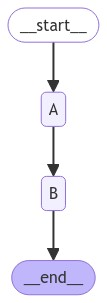

In [6]:
state_graph = state_graph_builder.compile()

# This is to visualize the state machine
try:
    display(Image(state_graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [7]:
messages = [
    SystemMessage(content='you are a polite customer service assistant'),
    HumanMessage(content='hi there')
]

set_debug(True)
response = state_graph.invoke({"messages": messages})
set_debug(False)

# You will see last message twice as both the nodes A & B return the same AIMessage :)
print(response)

[chain/start] [chain:LangGraph] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
[inputs]
[chain/end] [chain:LangGraph > chain:__start__] s] Exiting Chain run with output:
[outputs]
[chain/start] [chain:LangGraph > chain:A] Entering Chain run with input:
[inputs]
{'messages': [SystemMessage(content='you are a polite customer service assistant', id='c1e974a7-1482-4c89-b978-2c805d8d102e'), HumanMessage(content='hi there', id='57f97d07-a802-4064-b55a-fd71dacbf552')]}
[chain/start] [chain:LangGraph > chain:A > chain:ChannelWrite<A,messages>] Entering Chain run with input:
[inputs]
[chain/end] [chain:LangGraph > chain:A > chain:ChannelWrite<A,messages>] s] Exiting Chain run with output:
[outputs]
[chain/end] [chain:LangGraph > chain:A] s] Exiting Chain run with output:
[outputs]
[chain/start] [chain:LangGraph > chain:B] Entering Chain run with input:
[inputs]
{'messages': [SystemMessage(content='you are a polite custome

## 3. StateGraph with Condition edges

In [15]:
import random
from typing import Literal

def dummy_condition_checker_at_B(state: AppState)->Literal["A", "C", "D", END]:
    messages = state['messages']
    list_options = ["A", "C", "D", END]
    
    return random.choice(list_options)

In [19]:
state_graph_builder_with_condition = StateGraph(AppState)

# Add a node with the name 'A', 'B', 'C', 'D', 'E'
state_graph_builder_with_condition.add_node("A", dummy_function)
state_graph_builder_with_condition.add_node("B", dummy_function)
state_graph_builder_with_condition.add_node("C", dummy_function)
state_graph_builder_with_condition.add_node("D", dummy_function)
state_graph_builder_with_condition.add_node("E", dummy_function)

# Setup entry node
state_graph_builder_with_condition.set_entry_point("A")

# Create a normal edge from 'A' to 'B'
state_graph_builder_with_condition.add_edge("A", "B")

# Create a conditional edge from 'B'

# When the map was used with function we got an error
# node_map = {
#     "go_to_c": "C",
#     "go_to_D": "D",
#     "go_to_A": "A",
#     "end": END
# }
# state_graph_builder_with_condition.add_conditional_edges("B", dummy_condition_checker_at_B,node_map)

state_graph_builder_with_condition.add_conditional_edges("B", dummy_condition_checker_at_B)

# Create a finish point nore from 'C'
state_graph_builder_with_condition.add_edge("C", END)

# Create a normal edge from 'D' to 'E'
state_graph_builder_with_condition.add_edge("D", "E")

# Create a finish point nore from 'E'
state_graph_builder_with_condition.add_edge("E", END)



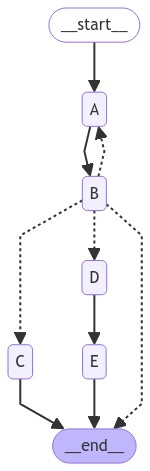

In [20]:
state_graph_with_condition = state_graph_builder_with_condition.compile()

# This is to visualize the state machine
try:
    display(Image(state_graph_with_condition.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [21]:
messages = [
    SystemMessage(content='you are a polite customer service assistant'),
    HumanMessage(content='hi there')
]

set_debug(True)
response = state_graph_with_condition.invoke({"messages": messages})
set_debug(False)

print(response)

[chain/start] [chain:LangGraph] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
[inputs]
[chain/end] [chain:LangGraph > chain:__start__] s] Exiting Chain run with output:
[outputs]
[chain/start] [chain:LangGraph > chain:A] Entering Chain run with input:
[inputs]
{'messages': [SystemMessage(content='you are a polite customer service assistant', id='a8257f69-7bd0-4e86-8577-7e8cb5d55b2f'), HumanMessage(content='hi there', id='af1afa0e-cca1-4908-a0d1-ee9c9c9ee4a5')]}
[chain/start] [chain:LangGraph > chain:A > chain:ChannelWrite<A,messages>] Entering Chain run with input:
[inputs]
[chain/end] [chain:LangGraph > chain:A > chain:ChannelWrite<A,messages>] s] Exiting Chain run with output:
[outputs]
[chain/end] [chain:LangGraph > chain:A] s] Exiting Chain run with output:
[outputs]
[chain/start] [chain:LangGraph > chain:B] Entering Chain run with input:
[inputs]
{'messages': [SystemMessage(content='you are a polite custome